# Řešení diferenciálních rovnic s okrajovou podmínkou


V předchozím cvičení jsme se zabývali metodami na řešení *počáteční úlohy* tvaru:

$$
\frac{d \vec{y}}{dx} = f(x, \vec{y}), \quad \vec{y}(0) = \vec{y}_0.
$$

Tato úloha představuje soustavu obyčejných diferenciálních rovnic 1. řádu s počáteční podmínkou $\vec{y}(0) = \vec{y}_0$. Tedy známe řešení $\vec{y}$ v nějakém konkrétním bodě.

V dnešním cvičení si představíme numerické metody řešící *okrajové úlohy*. Oproti počáteční úloze budeme znát část řešení ve více bodech. Pro $N=2$ můžeme například mít $y_0(0) = 0$ a $y_1(1) = 0$ nebo $y_0(0) = 0$ a $y_0(1) = 0$. Druhý případ je běžnější, proto se dále budeme zabývat pouze jím.

Omezíme se na řešení soustavy **dvou** ODR, která odpovídá diferenciální rovnici druhého řádu:

$$ 
y^{\prime \prime} = f(x, y(x), y^{\prime}(x)), \quad x \in [a, b], \quad y(a) = \alpha_1, \quad y(b) = \alpha_2,
$$

kde máme dvě okrajové podmínky pro funkci $y$ v bodech $a$ a $b$. Okrajová úloha již nelze řešit stejným způsobem, jako počáteční. Neznáme totiž celé jednoznačné řešení (hodnotu funkce $y$ i její derivace $y^{\prime}$) v jednom konkrétním bodě, ze kterého bychom mohli řešení vyvíjet - integrovat pravou stranu soustavy ODR.

Zde si představíme dvě metody na řešení okrajových úloh:
* Metoda střelby
* Metoda sítí (konečných diferencí)

Potřebné knihovny:

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, integrate, optimize

Pomocí metod budeme řešit následující úlohu, která odpovídá rovnici [tlumeného oscilátoru](https://en.wikipedia.org/wiki/Harmonic_oscillator#Damped_harmonic_oscillator):

$$
y^{\prime \prime} \left( t \right) + 2 \zeta \omega_0 y^{\prime} \left( t \right) + \omega_0^2 y \left( t \right) = 0, \quad t \in [0, \, 2], \quad y \left( 0 \right) = 1, \quad y \left( 2 \right) = 0,
$$

kde $\omega_0 = 10$ je *vlastní frekvence oscilátoru* a $\zeta = \frac{1}{10}$ je *tlumící faktor*.

Rovnice má obecné řešení:

$$
y(t) = A e^{-\zeta \omega_0 t} \sin{\left(\sqrt{1 - \zeta^2} \omega_0 t + \varphi\right)}
$$


Pro naší volbu koeficientů a okrajové podmínky máme:

$$
y \left( t \right) = -\frac{\exp{\left( -t \right)} \sin \left[ 3 \sqrt{11} \left( t - 2 \right) \right]}{\sin \left( 6 \sqrt{11} \right) }
$$

na intervalu $ t \in [0, 2] $.

In [83]:
# analyticke reseni rovnice tlumeneho oscilatoru

def y_sol(t):
    return -(np.exp(-t) * np.sin(3 * np.sqrt(11) * (t - 2))) / np.sin(6*np.sqrt(11))

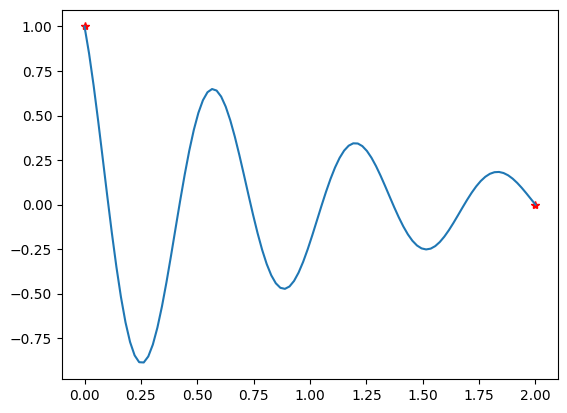

In [84]:
tt = np.linspace(0, 2, 100)
plt.plot([0, 2], [1, 0], 'r*')
plt.plot(tt, y_sol(tt));

## Metoda střelby

Tato metoda je inspirovaná úlohou střelby na cíl v homogenním gravitačním poli Země.

![Střelba z kanónu](../images/shootingmethod.png)

Řekněme, že máme kanón na pozici $x = a$ a cíl na pozici $x = b$. Zřejmě nás zajímá, pod jakým úhlem vystřelit a jakou silou (kolik použít střelného prachu), aby koule zasáhla cíl. Víme, že hmotný objekt se v gravitačním poli Země řídí pohybovou rovnicí (zde neuvažujeme odpor vzduchu):

$$
m \ddot{\vec{r}} = - m\vec{g}.
$$

Na začátku známe pouze polohu kanónu a cíle, což odpovídá:

$$
\vec{r}(0) = [x_0, y_0] = [a, 0], \quad \vec{r}(T) = [x_T, y_T] = [b, 0],
$$

kde $T$ značí čas dopadu koule zpátky na zem. Tato úloha je *okrajovou úlohou*, jelikož známe použe část řešení (polohy ale ne rychlosti) na začátku a na konci. Bez znalosti počátečních rychlostí (velikosti rychlosti a náměru děla) nedokážeme řešení vyvíjet integrováním pravé strany.
Metodu střelby si dále ukázeme na obecné diferenciální rovnici 2. řádu a k úloze střelby z kanónu se vrátíme v [zápočtovém úkolu 5](ukol5). 

Uvažujme opět následující okrajovou úlohu s ODR druhého řádu:

$$ 
y^{\prime \prime} = f(x, y(x), y^{\prime}(x)), \quad x \in [a, b], \quad y(a) = \alpha_1, \quad y(b) = \alpha_2,
$$

Řešení pomocí **metody střelby** spočívá v následujících krocích:
1. náhodně zvolíme počáteční hodnotu derivace $y^{\prime}(a) = \beta$
2. vyřešíme počáteční úlohu:

$$
\begin{align}
& y^{\prime}(x) = z(x), \quad &y(a) = \alpha_1 \\
& z^{\prime}(x) = f(x, y(x), z(x)), \quad &z(a) = y^{\prime}(a) = \beta
\end{align}
$$

3. tím získáme $y(b; \beta)$
4. řešíme nelineální rovnici $F(\beta) = y(b; \beta) - \alpha_2 = 0$ tím, že opakujeme kroky 1-3

Na krok 4 je možné aplikovat libovolnou z metod představených v [předchozím cvičení](nelin-rce). Jednoduchou volbou je *bisekce*, tedy máme na začátku dva odhady $\beta_1$ a $\beta_2$ takové, že $F(\beta_1) F(\beta_2) < 0$ (jednou přestřelíme cíl, podruhé podstřelíme). V následujícím kódu použijeme *Newton-Raphsonovu metodu*.

Ukážeme si implementaci metody střelby na úloze *tlumeného oscilátoru*. Počáteční úloha z bodu 2 metody vypadá následovně:

$$
\begin{align}
& y^{\prime}(t) = z(t), \quad &y(0) = 1 \\
& z^{\prime}(t) = -2 z(t) - 100 y (t), \quad &z(0) = y^{\prime}(0) = \beta
\end{align}
$$

In [85]:
# definice prave strany pocatecni ulohy
def f(t, Y):
    y, z = Y  # Y je vektor reseni [y, z]
    return np.array([z, -2*z - 100*y])

# okrajove podminky
x0 = 0
x1 = 2
y0 = 1
y1 = 0

Řešení počáteční úlohy pro jednu konkrétní volbu $\beta$:

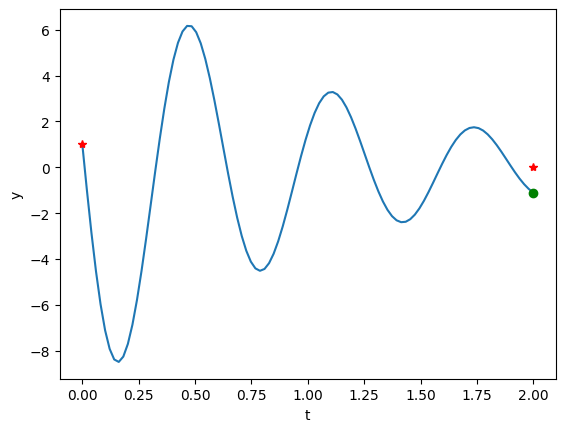

In [86]:
beta = -100

# druha pocatecni podminka
z0 = beta

res = integrate.solve_ivp(f, [x0, x1], [y0, z0], method='RK45', t_eval = tt)

plt.plot(res.t, res.y[0])  # y[0] odpovida y, y[1] odpovida z=y'
plt.plot([2], [res.y[0, -1]], 'go')
plt.plot([0, 2], [y0, y1], 'r*')
plt.xlabel('t')
plt.ylabel('y');

**Implementace metody střelby**

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Pomocí metody střelby řešte úlohu *tlumeného oscilátoru*.

Defininujte funkci $F(\beta)$ podle postupu *metody střelby*. Najděte kořen této funkce (`beta_root`) pomocí knihovní funkce `optimize.root_scalar(..., method='newton')`. Budete potřebovat také darivaci funkce $F(\beta)$. Použijte aproximaci této derivace pomocí dopředné diference (numerická derivace).
</p>
</div>
</div>

In [87]:
def F(beta):
    ## DOPLŇTE - definice funkce na hledani korene ##
    return None

# numericka derivace
def dF(beta, h = 0.00001): 
    ## DOPLŇTE - numericka derivace funkce F(beta) ##
    return None

## DOPLŇTE - hledani korene, Newton-Ralphson ##
res_root = optimize.root_scalar(F, fprime=dF, x0=0, method='newton', rtol=1e-6)

print(res_root)
beta_root = res_root.root

      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 4
           root: array([-6.65510418])


**Vizualizace řešení**

Nalezením kořene $\beta^{*}$, $F(\beta^{*}) = 0$, jsme získali počáteční podmínku takovou, že *okrajová* a *počáteční* úloha jsou ekvivalentní. Okrajovou úlohu vyřešíme vyřešením počáteční úlohy s $z(0) = \beta^{*}$:

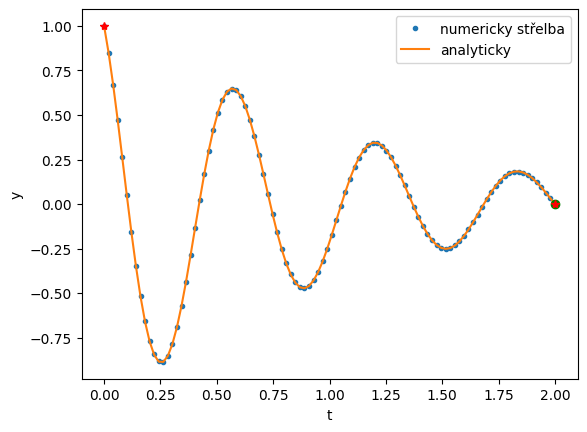

In [88]:
res_ivp = integrate.solve_ivp(f, [x0, x1], [y0, beta_root], method='RK45', t_eval = tt)

plt.plot(res_ivp.t, res_ivp.y[0], '.', label='numericky střelba')  # y[0] odpovida y, y[1] odpovida z=y'
plt.plot(res_ivp.t, y_sol(res_ivp.t), '-', label='analyticky')  # presne reseni
plt.plot([2], [res_ivp.y[0, -1]], 'go')
plt.plot([0, 2], [y0, y1], 'r*')
plt.xlabel('t')
plt.ylabel('y')
plt.legend();

In [89]:
# srovnani reseni na pravem okraji
res_ivp.y[0][-1], y_sol(x1)

(-2.7755575615628914e-17, -0.0)

## Metody sítí (konečných diferencí)

[Metoda konečných diferencí](https://en.wikipedia.org/wiki/Finite_difference_method), také nazývaná metodou sítí nebo relaxační metodou, je založená na nahrazení derivací v diferenciální rovnici pomocí konečných diferencí. Tím získáme algebraický výraz, který již dokážeme řešit na počítači. Uvažujeme následující ODR 2. řádu s *okrajovou podmínkou*:

$$
p \left(x \right) y^{\prime \prime} \left( x \right) + q \left(x \right) y^{\prime} \left( x \right) + r \left(x \right) y \left( x \right) + s \left(x \right) = 0, \quad x \in [a, b], \quad y(a) = \alpha_1, \quad y(b) = \alpha_2.
$$

Provedeme nahrazení jednotlivých derivací pomocí následujících aproximací pomocí konečných diferencí, které počítáme na *rovnoměrné síti* na intervalu $[a, b]$ s krokem $h$:

$$
y_i^{\prime} \approx \frac{y_{i + 1} - y_{i}}{h} \quad \mathrm{a} \quad y_i^{\prime \prime} \approx \frac{y_{i + 1} - 2 y_{i} + y_{i - 1}}{h^2}, \quad i = 0, \dots, n - 1.
$$

Okrajovou úlohu pak můžeme přepsat jako soustavu lineárních algebraických rovnic:

$$
\tilde{p_i} y_{i - 1} + \tilde{q_i} y_i + \tilde{r_i} y_{i + 1} = \tilde{s_i}, \quad y_0 = \alpha_1, \quad y_{n - 1} = \alpha_2,
$$

kde $ \tilde{p_i} = p_i $, $ \tilde{q_i} = \left( -2 p_i - q_i h + r_i h^2 \right) $, $ \tilde{r_i} = \left(p_i + q_i h \right) $ a $ \tilde{s_i} = -s_i h^2 $.

V maticové formě má systém lineárních rovnic tvar:

$$
\begin{pmatrix}
1 &  &  &  &  \\
\tilde{p}_1 & \tilde{q}_1 & \tilde{r}_1 & &  \\
 & \ddots & \ddots  & \ddots & \\
 &  & \tilde{p}_{n - 2} & \tilde{q}_{n - 2} & \tilde{r}_{n - 2} \\
 &  &  &  & 1 \\
\end{pmatrix} 
\begin{pmatrix}
y_0 \\
y_1 \\
\vdots\\
y_{n-2} \\
y_{n-1}
\end{pmatrix} =
\begin{pmatrix}
\alpha_1 \\
\tilde{s}_1 \\
\vdots \\
\tilde{s}_{n-2} \\
\alpha_2
\end{pmatrix}.
$$

Tato metoda se někdy nazývá relaxační metodou, jelikož typicky řešíme velkou soustavu linearních rovnic pomocí *iteračního algoritmu*. Tedy máme nějaký počáteční odhad, který iteračně zlepšujeme (viz [předchozí kapitola](https://mjirka.github.io/nme/Cviceni04vyplnene.html)). V případě diferenciální rovnice 2. řádu vidíme, že soustava je třidiagonální, stačilo by tedy využít *Thomasova algoritmu*!

Pomocí této metody budeme opět řešit úlohu tlumeného oscilátoru:

$$
y^{\prime \prime} \left( t \right) + 2  y^{\prime} \left( t \right) + 100 y \left( t \right) = 0, \quad t \in [0, \, 2], \quad y \left( 0 \right) = 1, \quad y \left( 2 \right) = 0.
$$

Postup metody konečných diferencí lze shrnout do následujících kroků:
1. Zvolíme tvar konečných diferencí, kterými nahradíme jednotlivé derivace.
2. Získáme soustavu lineárních rovnic - sestavíme matici soustavy a pravou stranu.
3. Řešíme soustavu pomocí zvoleného algoritmu.

**Implementace metodu konečných diferencí**

<div style="margin-top: 25px; margin-bottom: 25px; padding-top: 0px; padding-bottom: 0px; padding-left: 0px; padding-right: 0px; border-radius: 4px; border-color: #E0B32C; border-right-width: 1px; border-top-width: 1px; border-bottom-width: 1px; border-left-width: 3px; border-style: solid">
<div style="background: #FFF3CD; color: #000000; padding-left: 20px; padding-top: 10px; padding-bottom: 10px; border-radius: 1px 3px 0px 0px; font-weight: 600">Úkol</div>
<div style="padding-left: 20px; padding-right: 20px; padding-top: 0px; padding-bottom: 0px; border-radius: 0px 0px 3px 3px">
<p>

Pomocí metody konečných diferencí řešte úlohu *tlumeného oscilátoru*.
</p>
</div>
</div>

In [90]:
a = 0
b = 2

# okrajove podminky
alpha1 = 1
alpha2 = 0

## 1. volíme diference podle predchoziho popisu pro obecnou ODR 2. radu
N = 101  # velikost site
h = (b - a) / (N-1)
tt = np.linspace(a, b, N)

## 2. sestaveni matice a prave strany

# koeficienty p_i, q_i, r_i a s_i nezavisi na t !
p_i = 1
q_i = -2 - 2*h + 100*h**2
r_i = 1 + 2*h
s_i = 0

# matice soustavy
A = np.zeros([N, N])
A[0,0] = A[-1,-1] = 1
idx = np.arange(0, N-1)
A[idx[:-1]+1,idx[:-1]] = p_i        # spodni vedlejsi diagonala
A[idx[1:],idx[1:]] = q_i  # diagonala
A[idx[1:],idx[1:]+1] = r_i  # diagonala

# prava strana
b = np.zeros(N)
b[0] = alpha1
b[1:-1] = s_i
b[-1] = alpha2

## 3. vyreseni soustavy
y = linalg.solve(A, b)

In [91]:
A, b

(array([[ 1.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
        [ 1.  , -2.  ,  1.04, ...,  0.  ,  0.  ,  0.  ],
        [ 0.  ,  1.  , -2.  , ...,  0.  ,  0.  ,  0.  ],
        ...,
        [ 0.  ,  0.  ,  0.  , ..., -2.  ,  1.04,  0.  ],
        [ 0.  ,  0.  ,  0.  , ...,  1.  , -2.  ,  1.04],
        [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  1.  ]]),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

**Vizualizace řešení**

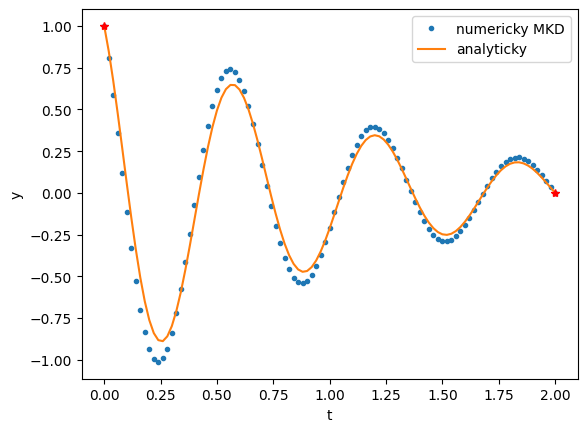

In [92]:
plt.plot(tt, y, '.', label='numericky MKD')  # y[0] odpovida y, y[1] odpovida z=y'
plt.plot(tt, y_sol(tt), '-', label='analyticky')  # presne reseni
plt.plot([0, 2], [y0, y1], 'r*')
plt.xlabel('t')
plt.ylabel('y')
plt.legend();

Knihovna SciPy poskytuje funkci `scipy.integrate.solve_bvp()` pro řešení okrajových úloh:

In [93]:
y_init = np.zeros([2,N])  # pocatecni odhad
res_bvp = integrate.solve_bvp(f, lambda ya, yb: np.array([ya[0]-alpha1, yb[0] - alpha2]), tt, y_init)
#print(res_bvp)

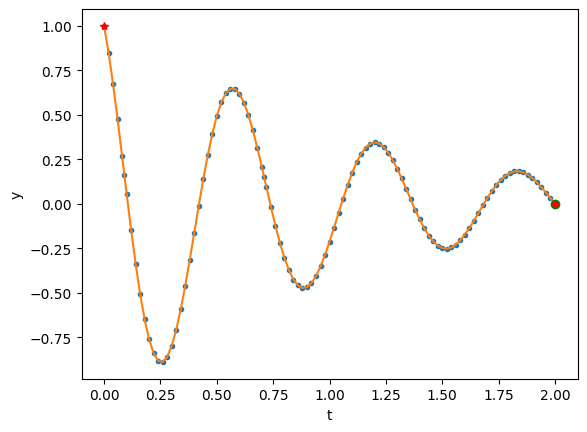

In [94]:
plt.plot(res_bvp.x, res_bvp.y[0], '.', label='numericky střelba')  # y[0] odpovida y, y[1] odpovida z=y'
plt.plot(res_bvp.x, y_sol(res_bvp.x), '-', label='analyticky')  # presne reseni
plt.plot([2], [res_bvp.y[0, -1]], 'go')
plt.plot([0, 2], [y0, y1], 'r*')
plt.xlabel('t')
plt.ylabel('y');